<a href="https://colab.research.google.com/github/wisnudj/H8_PTP_Final_Image/blob/master/CatDog-Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D, Convolution2D, Flatten, Dropout, MaxPooling2D, MaxPool2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

import os
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
tf.__version__

'2.0.0'

In [4]:
pip install tensorflow-gpu==2.0

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


## Load Data

In [7]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 1s 0us/step


In [0]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [0]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

## Understand the data

Berapa banyak gambar anjing dan kucing training dan validation dataset

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [11]:

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)


total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


Setting variable untuk digunakan saat preprocessing dataset dan training network

In [0]:
batch_size = 128
epochs = 10
IMG_HEIGHT = 64
IMG_WIDTH = 64

## Data Preparation and Augmented

Format image menjadi tensor float sebelum di train:
* Read image dari disk
* Decode image dan convert menjadi grid format sesuai dengan rgb
* konvert menjadi float
* rescale nilai nya dari range 0 - 255 menjadi 0 - 1
* Augmented data



In [13]:
train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data


train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode="binary")


val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode="binary")


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Visualize Training Image

Visualisasi training image dengan mengekstrak satu batch image dan di plot menggunakan matplotlib

In [0]:
# Fungsi ini untuk memplot image 5 x 5 image
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title("dog" if label_batch[n] == 1.0 else "cat")
      plt.axis('off')

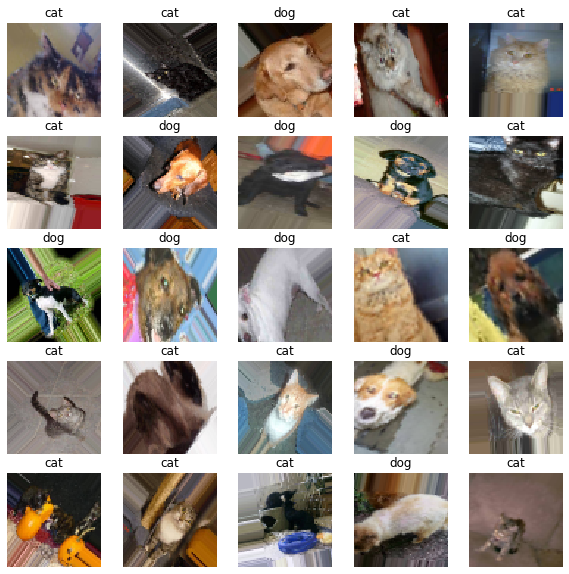

In [15]:
sample_training_images, sample_training_label = next(train_data_gen)
show_batch(sample_training_images, sample_training_label)

## Model

In [0]:
#Initializing CNN
model = Sequential()

#Adding 1st Convolution Layer
model.add(Convolution2D(filters=32, kernel_size=(3,3), strides=(1,1), input_shape=(IMG_HEIGHT,IMG_WIDTH,3), activation='relu', padding='same'))

#Adding 1st MaxPooling Layer to reduce the size of feature map
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2) ))

#Adding 1st BatchNormalization Layer for higher Learning Rate
model.add(BatchNormalization())

#Adding 1st Dropout Layer to eliminate overfitting
model.add(Dropout(0.2))

#Adding 2nd Convolution Layer
model.add(Convolution2D(filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))

#Adding 2nd MaxPooling Layer to reduce the size of feature map
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#Adding 2nd BatchNormalization Layer for higher Learning Rate
model.add(BatchNormalization())

#Adding 2nd Dropout Layer to eliminate overfitting
model.add(Dropout(0.2))

#Adding Flatten Layer to convert 2D matrix into an array
model.add(Flatten())

#Adding Fully connected layer
model.add(Dense(units=32,activation='relu'))

#Adding Output Layer
model.add(Dense(units=1,activation='sigmoid'))

In [0]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        6

In [19]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val
)

Epoch 1/10
2000/2000 [==============================] - 1190s 595ms/step - loss: 0.5066 - accuracy: 0.7458 - val_loss: 0.6684 - val_accuracy: 0.7040
Epoch 2/10
2000/2000 [==============================] - 1157s 579ms/step - loss: 0.3972 - accuracy: 0.8169 - val_loss: 0.7216 - val_accuracy: 0.7480
Epoch 3/10
2000/2000 [==============================] - 1168s 584ms/step - loss: 0.3579 - accuracy: 0.8390 - val_loss: 0.8338 - val_accuracy: 0.7200
Epoch 4/10
2000/2000 [==============================] - 1171s 585ms/step - loss: 0.3343 - accuracy: 0.8518 - val_loss: 0.7097 - val_accuracy: 0.7570
Epoch 5/10
2000/2000 [==============================] - 1165s 583ms/step - loss: 0.3192 - accuracy: 0.8602 - val_loss: 1.4258 - val_accuracy: 0.7090
Epoch 6/10
2000/2000 [==============================] - 1166s 583ms/step - loss: 0.3060 - accuracy: 0.8661 - val_loss: 0.6914 - val_accuracy: 0.7600
Epoch 7/10
2000/2000 [==============================] - 1163s 582ms/step - loss: 0.2941 - accuracy: 0.8721

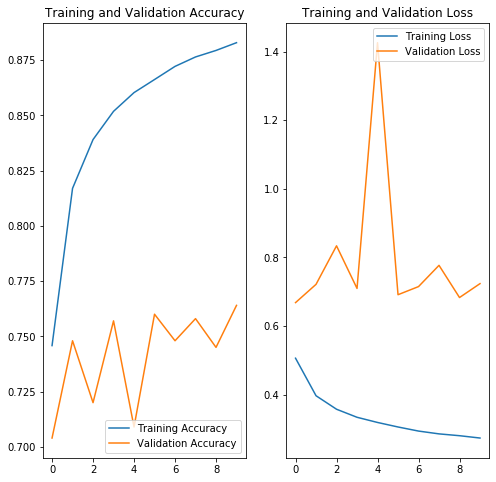

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Berdasarkan grafik diatas dapat dilihat bahwa training accuracy mengalami peningkatan dan loss terus mengalami penurunan namun validation loss mengalami peningkatan. Ini berarti bahwa model mulai cenderung overfit yang kemudian dapat dilihat kecendrungannya bahwa training accuracy jauh lebih tinggi dibandingkan dengan validasi accuracy

## Predict

In [0]:
# Fungsi ini untuk memplot image 5 x 5 image kh
def compare_actual_predict_batch(image_batch, actual_label_batch, predict_label_batch):
  plt.figure(figsize=(20,20))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      actual_state = "dog" if actual_label_batch[n] == 1.0 else "cat"
      predict_state = "dog" if predict_label_batch[n] == 1.0 else "cat"
      title = f"actual: {actual_state}, predict: {predict_state}"
      plt.title(title)
      plt.axis('off')


In [0]:
sample_validation_images, sample_validation_label = next(val_data_gen)

In [0]:
res_predict = model.predict(sample_validation_images)

In [0]:
res_predict[res_predict > 0.5] = 1
res_predict[res_predict <= 0.5] = 0

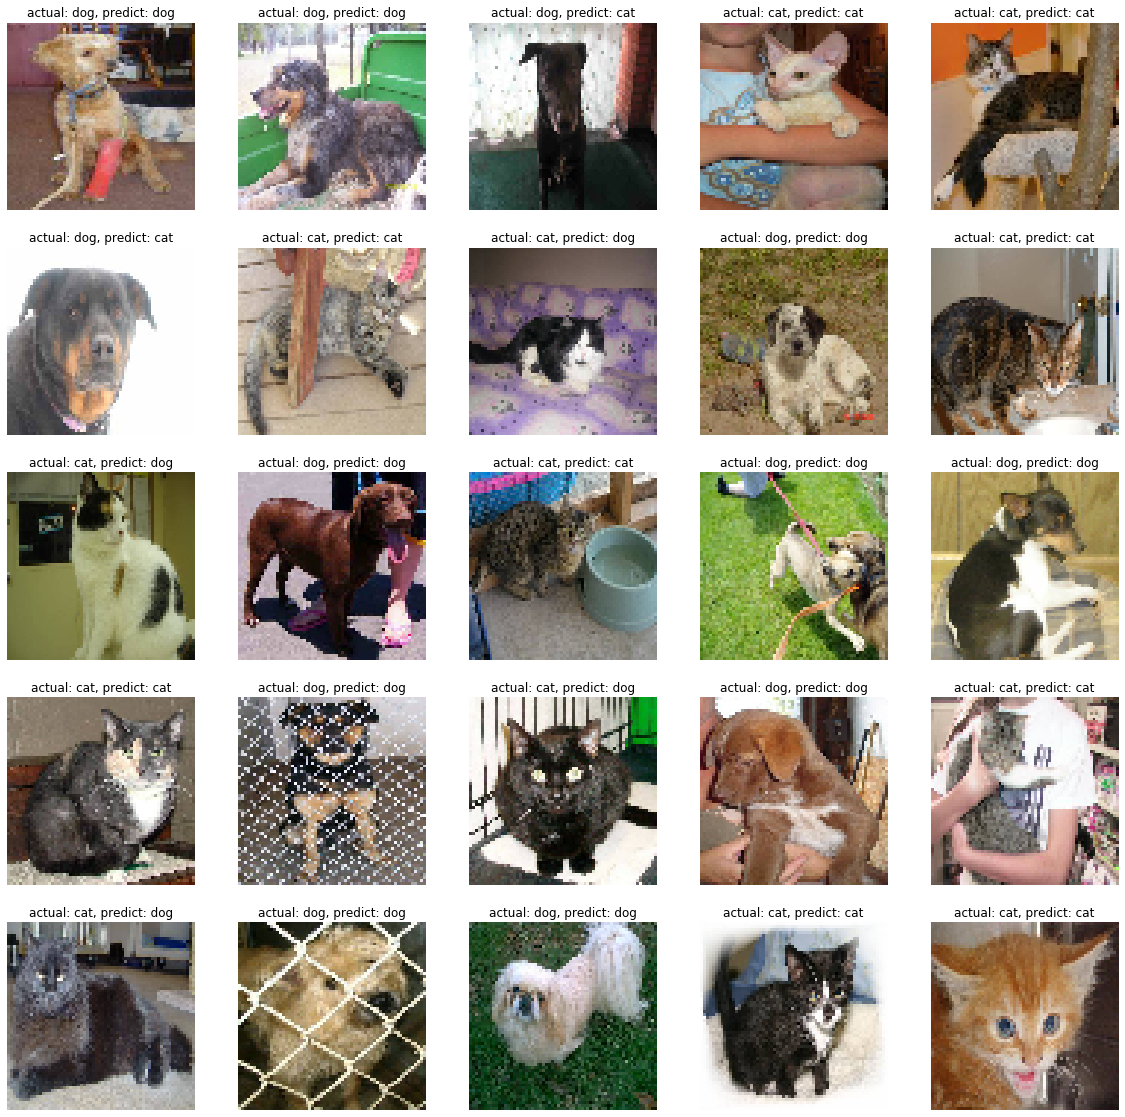

In [46]:
compare_actual_predict_batch(sample_validation_images, sample_validation_label, res_predict)